In [27]:
import numpy as np
import random
from proglearn.sims import generate_gaussian_parity
import matplotlib.pyplot as plt

# k sample testing from hyppo
from hyppo.ksample import KSample
from hyppo.tools import rot_ksamp

from proglearn.forest import LifelongClassificationForest, UncertaintyForest
from proglearn.sims import *
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

from joblib import Parallel, delayed

from math import log2, ceil

In [61]:
# define angles
angles = range(0, 95, 5)

# samples to use per distribution
n_samples = 500

# generate xor
X_xor, y_xor = generate_gaussian_parity(n_samples)

# define array to store gen error
gen_error = np.zeros(len(angles))

# number of repetitions to run the omnidirectional learning algorithm
mc_rep = 100

In [132]:
def experiment(n_samples, X_xor, y_xor, rxor_angle, max_depth=None, n_trees=10):
    # generate rxor
    X_rxor, y_rxor = generate_gaussian_parity(n_samples, angle_params=rxor_angle)

    progressive_learner = LifelongClassificationForest(default_n_estimators=n_trees)
    # uf1 = LifelongClassificationForest(default_n_estimators=n_trees)

    # p value <= 0.05 learn new transformer
    if KSample(indep_test="Dcorr").test(X_xor, X_rxor)[1] <= 0.05:
        progressive_learner.add_task(X_xor, y_xor, n_estimators=n_trees)
        progressive_learner.add_task(X_rxor, y_rxor, n_estimators=n_trees, task_id=1)
        progressive_learner.add_transformer(X_rxor, y_rxor, n_estimators=n_trees)
        predict_2task = progressive_learner.predict(X_rxor, task_id=1)
        gen_err = 1 - np.mean(predict_2task == y_rxor)
    else:
        # else continue adding xor data
        progressive_learner.add_task(X_xor, y_xor, n_estimators=n_trees)
        predict_2task = progressive_learner.predict(X_rxor, task_id=0)
        gen_err = 1 - np.mean(predict_2task == y_rxor)
    return gen_err

In [133]:
# run experiment with varying angles
for i, angle in enumerate(range(0, 95, 5)):
    error = np.array(
        Parallel(n_jobs=-1, verbose=0)(
            delayed(experiment)(
                n_samples,
                X_xor,
                y_xor,
                rxor_angle=np.radians(angle),
                max_depth=ceil(log2(n_samples)),
            )
            for _ in range(mc_rep)
        )
    )
    gen_error[i] = np.mean(error)

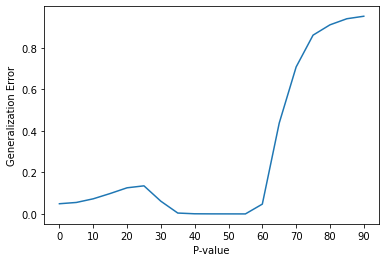

In [134]:
# plot angles vs gen error
plt.xlabel("P-value")
plt.xticks(np.arange(min(angles), max(angles)+5, 10.0))
plt.ylabel("Generalization Error")
plt.plot(angles, gen_error)